In [1]:
import torch 
import torchvision
import torchvision.models as models 
import torch.nn as nn 
import torch.nn.functional as F 
import numpy as np 
import matplotlib.pyplot as plt 

from torchvision.datasets import CIFAR10 
from torch.utils.data import DataLoader 
from torch.optim import Adam 
from torchvision import datasets, transforms 
from torchsummary import summary 

torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'


#### Data

In [2]:
train_transform = transforms.Compose(
    [ 
        transforms.Resize((224, 224)), 
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225]), 
        transforms.RandomErasing(p=0.75, 
                                 scale=(0.001, 0.3), 
                                 ratio=(1.0, 1.0), 
                                 value=0, 
                                 inplace=True)
    ]
)

test_transform = transforms.Compose(
    [ 
        transforms.Resize((224, 224)), 
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.485, 0.456, 0.405], 
                             std=[0.229, 0.224, 0.225])
    ]
)

train_dataset = datasets.ImageFolder('../data50/train', transform=train_transform)
test_dataset = datasets.ImageFolder('../data50/validation', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Model

In [3]:
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
f_extractor = vgg16.features 

for param in f_extractor.parameters():
    param.requires_grad = False 

for name, module in f_extractor.named_modules():
    if hasattr(module, 'parameters'):
        is_trainable = any(param.requires_grad for param in module.parameters())
        print(f"{name}: {'Trainable' if is_trainable else 'Not trainable'}")

: Not trainable
0: Not trainable
1: Not trainable
2: Not trainable
3: Not trainable
4: Not trainable
5: Not trainable
6: Not trainable
7: Not trainable
8: Not trainable
9: Not trainable
10: Not trainable
11: Not trainable
12: Not trainable
13: Not trainable
14: Not trainable
15: Not trainable
16: Not trainable
17: Not trainable
18: Not trainable
19: Not trainable
20: Not trainable
21: Not trainable
22: Not trainable
23: Not trainable
24: Not trainable
25: Not trainable
26: Not trainable
27: Not trainable
28: Not trainable
29: Not trainable
30: Not trainable


In [4]:
model = nn.Sequential(f_extractor, 
                      nn.Flatten(), 
                      nn.Dropout(0.3), 
                      nn.Linear(512*7*7, 512),
                      nn.ReLU(),
                      nn.Dropout(0.3),
                      nn.Linear(512, 2))
model.to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

#### Train

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

In [6]:
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0 
    running_correct = 0 
    total = 0 
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100 * running_correct / total 
    test_loss = test_loss / len(test_loader)
    return test_loss, accuracy

In [7]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 10

In [8]:
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0 
    running_correct = 0.0 
    total = 0 

    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_correct += loss.item()

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

    epoch_accuracy = 100 * running_correct / total 
    epoch_loss = running_loss / (i + 1)

    test_loss, test_accuracy = evaluate(model, test_loader, criterion)
    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/10], Loss: 0.0000, Accuracy: 69.03%, Test Loss: 0.1693, Test Accuracy: 94.80%
Epoch [2/10], Loss: 0.0000, Accuracy: 96.42%, Test Loss: 0.1071, Test Accuracy: 96.00%
Epoch [3/10], Loss: 0.0000, Accuracy: 99.15%, Test Loss: 0.1040, Test Accuracy: 95.90%
Epoch [4/10], Loss: 0.0000, Accuracy: 100.06%, Test Loss: 0.1081, Test Accuracy: 95.80%
Epoch [5/10], Loss: 0.0000, Accuracy: 100.02%, Test Loss: 0.1096, Test Accuracy: 96.10%
Epoch [6/10], Loss: 0.0000, Accuracy: 100.02%, Test Loss: 0.1102, Test Accuracy: 96.10%
Epoch [7/10], Loss: 0.0000, Accuracy: 99.07%, Test Loss: 0.1065, Test Accuracy: 96.50%
Epoch [8/10], Loss: 0.0000, Accuracy: 100.02%, Test Loss: 0.1156, Test Accuracy: 96.00%
Epoch [9/10], Loss: 0.0000, Accuracy: 100.01%, Test Loss: 0.1266, Test Accuracy: 95.70%
Epoch [10/10], Loss: 0.0000, Accuracy: 100.02%, Test Loss: 0.1220, Test Accuracy: 95.90%


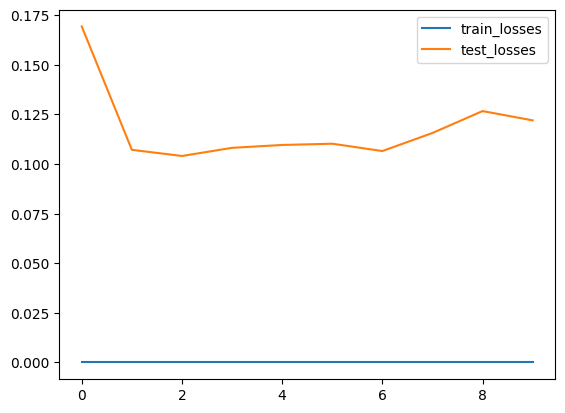

In [9]:
import matplotlib.pyplot as plt 

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

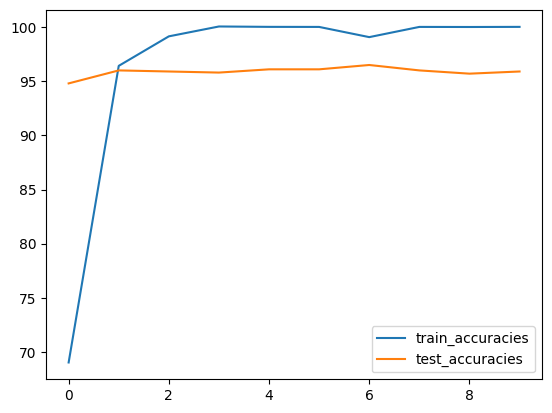

In [10]:
import matplotlib.pyplot as plt 

plt.plot(train_accuracies, label="train_accuracies")
plt.plot(test_accuracies, label="test_accuracies")
plt.legend()